# Advance Computer Vision

## Exercise Sheet 9

### Task 1 – Transfer Learning with U-Net Model in Python

tensorflow/datasets is a library of public datasets ready to use with TensorFlow. Each dataset definition contains the logic necessary to download and prepare the dataset, as well as to read it into a model using the tf.data.Dataset API.

In [1]:
#Importing libraries

import os
import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import metrics
tf.random.set_seed(1)

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Pre-training with DeepWeeds dataset

The DeepWeeds dataset consists of 17,509 images capturing eight different weed species native to Australia in situ with neighbouring flora.The selected weed species are local to pastoral grasslands across the state of Queensland.

Classes: (1) chinee apple (Ziziphus mauritiana), (2) lantana (Lantana camara), (3) parkinsonia (Parkinsonia aculeata), (4) parthenium (Parthenium hysterophorus), (5) prickly acacia (Vachellia nilotica), (6) rubber vine (Cryptostegia grandiflora), (7) siam weed (Chromolaena odorata) and (8) snake weed (Stachytarpheta spp.)

In [ ]:
# Loads deep weeds data.
# Can subsample the data with <fraction> parameter to prevent exhausting memory
# def load_deepweeds(fraction=1.0):
#   train_x = []
#   train_y = []
#   ds = tfds.load('deep_weeds', split='train', as_supervised=True)
#   for image,label in tfds.as_numpy(ds):
#     if np.random.uniform(0,1) < fraction:
#       train_x.append(np.array(Image.fromarray(image).resize((224,224))))
#       train_y.append(label)
#   train_x = np.array(train_x)/255.0
#   train_y = tf.keras.utils.to_categorical(np.array(train_y))
#   return train_x, train_y

# weed_train_x, weed_train_y = load_deepweeds(fraction=0.2) #fraction changed bc of insufficient memory

# print("Shape of training X", weed_train_x.shape)

In [3]:
#Downloading dataset deep weeds

!gdown --no-check-certificate --quiet 'https://docs.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj' -O images.zip

!wget --no-check-certificate --quiet 'https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv' -O labels.csv

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'docs.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'docs.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doc-0g-as-docs.googleusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [4]:
#unziping the file
!unzip -q images.zip -d deep_weeds

In [5]:
# Paths
images_dir = './deep_weeds/'
csv_file = './labels.csv'

# Load CSV file
df = pd.read_csv(csv_file)

In [6]:
df['Label'].value_counts()

Label
8    9106
0    1125
6    1074
1    1064
4    1062
2    1031
3    1022
7    1016
5    1009
Name: count, dtype: int64

In [7]:
#Balancing out
df = df.sample(frac=0.1, random_state=42)
df['Label'].value_counts()

Label
8    909
3    115
4    110
5    108
1    107
6    107
0    103
2    100
7     92
Name: count, dtype: int64

In [8]:
# Create a list of image paths and labels
image_paths = [os.path.join(images_dir, filename) for filename in df['Filename']]

labels = df['Label'].tolist()

# Convert lists to TensorFlow tensors
image_paths_tensor = tf.constant(image_paths)
labels_tensor = tf.constant(labels)

In [11]:
def load_image(image_path):
    # Read the image from the file
    image = tf.io.read_file(image_path)
    # Decode it into a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize or preprocess image as needed
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0  # Normalize to [0, 1]
    return image

def preprocess(image_path, label):
    image = load_image(image_path)
    return image, label

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths_tensor, labels_tensor))
dataset = dataset.map(preprocess)
dataset = dataset.shuffle(buffer_size=1000)
len(dataset)

BATCH_SIZE = 32
dataset = dataset.batch(BATCH_SIZE)
dataset.prefetch(tf.data.AUTOTUNE) #Optimizes the data loading pipeline by prefetching data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

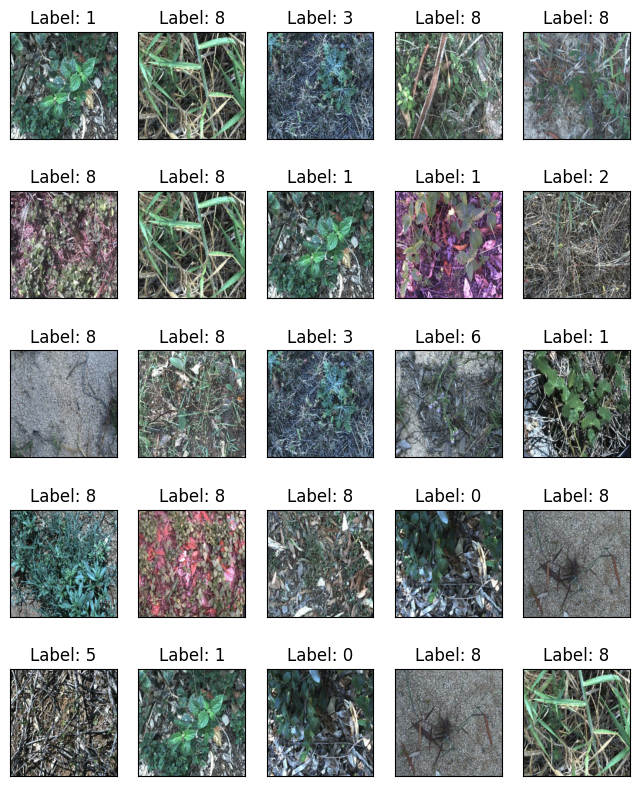

In [13]:
#Printing a random subset of training dataset along with the labels

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(8,10))

for images, labels in dataset:
    for i in range(5):
        for j in range(5):
            idx = np.random.randint(labels.shape[0])
            ax[i,j].set_title(f'Label: {labels[idx]}')
            ax[i,j].imshow(images[idx])
            ax[i,j].axes.yaxis.set_visible(False)
            ax[i,j].axes.xaxis.set_visible(False)

    break

Classification model

In [14]:
def classification_model(input_sample):
  (m,l,d) = input_sample.shape
  inputs = keras.Input(shape=(m,l,d),name='I')

  x = layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L1')(inputs)
  x2 = layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L2')(x)

  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2),name='L3')(x2)
  x = layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L4')(x)
  x5 = layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L5')(x)

  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2),name='L6')(x5)
  x = layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L7')(x)
  x8 = layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L8')(x)

  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2),name='L9')(x8)
  x = layers.Conv2D(filters=512,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L10')(x)
  x11 = layers.Conv2D(filters=512,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L11')(x)

  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2),name='L12')(x11)
  x = layers.Conv2D(filters=1024,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L13')(x)
  x = layers.Conv2D(filters=1024,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L14')(x)

  # x = layers.Activation(activations.softmax,name='A')(x)
  x = layers.BatchNormalization(name='BN')(x)

  x = layers.GlobalAveragePooling2D(name='GAP')(x)
  x = layers.Dense(9, activation='softmax', name='Dense')(x)

  outputs = x

  model = keras.Model(inputs=inputs, outputs=outputs, name="class_model")

  return model

In [32]:
image_example = next(iter(dataset))[0][0]

model_encoder = classification_model(image_example)
model_encoder.summary()

Model: "class_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 I (InputLayer)              [(None, 224, 224, 3)]     0         
                                                                 
 L1 (Conv2D)                 (None, 224, 224, 64)      1792      
                                                                 
 L2 (Conv2D)                 (None, 224, 224, 64)      36928     
                                                                 
 L3 (MaxPooling2D)           (None, 112, 112, 64)      0         
                                                                 
 L4 (Conv2D)                 (None, 112, 112, 128)     73856     
                                                                 
 L5 (Conv2D)                 (None, 112, 112, 128)     147584    
                                                                 
 L6 (MaxPooling2D)           (None, 56, 56, 128)       

In [33]:
EPOCHS = 10
LEARNING_RATE = 0.001

# LOSS = tf.keras.losses.CategoricalCrossentropy()
LOSS = tf.keras.losses.SparseCategoricalCrossentropy()

OPT = keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    clipnorm=1.0
)

# OPT = keras.optimizers.SGD(
#     learning_rate=LEARNING_RATE,
#     momentum=0.9
# )

model_encoder.compile(loss=LOSS, optimizer=OPT, metrics=['accuracy'])

In [34]:
%%time
history_1 = model_encoder.fit(dataset, epochs=EPOCHS)

Epoch 1/10
55/55 [==============================] - 24s 345ms/step - loss: 1.7970 - accuracy: 0.4746
Epoch 2/10
55/55 [==============================] - 20s 344ms/step - loss: 1.4661 - accuracy: 0.5306
Epoch 3/10
55/55 [==============================] - 20s 347ms/step - loss: 1.4407 - accuracy: 0.5254
Epoch 4/10
55/55 [==============================] - 21s 353ms/step - loss: 1.4142 - accuracy: 0.5283
Epoch 5/10
55/55 [==============================] - 20s 355ms/step - loss: 1.3805 - accuracy: 0.5363
Epoch 6/10
55/55 [==============================] - 21s 357ms/step - loss: 1.3602 - accuracy: 0.5385
Epoch 7/10
55/55 [==============================] - 21s 354ms/step - loss: 1.3518 - accuracy: 0.5306
Epoch 8/10
55/55 [==============================] - 21s 352ms/step - loss: 1.3510 - accuracy: 0.5431
Epoch 9/10
55/55 [==============================] - 21s 357ms/step - loss: 1.3587 - accuracy: 0.5385
Epoch 10/10
55/55 [==============================] - 21s 361ms/step - loss: 1.3379 - accura

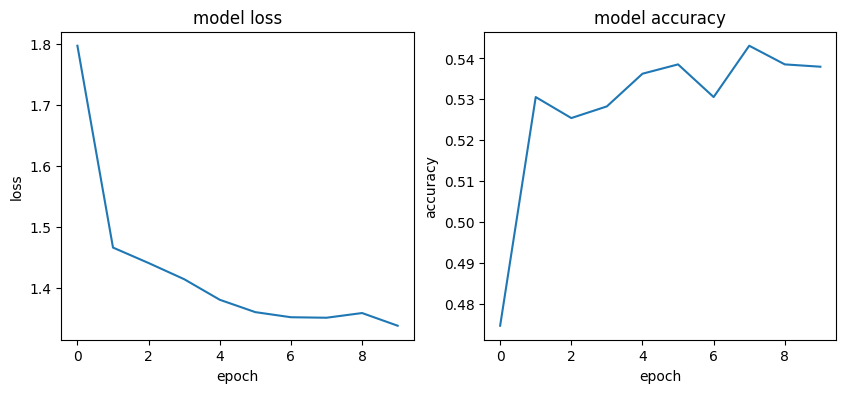

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(history_1.history['loss'])
axes[0].set_title('model loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')


axes[1].plot(history_1.history['accuracy'])
axes[1].set_title('model accuracy')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')

plt.show()

#### Fine tuning on Crop Weed Field Image Dataset (CWFID)

CWFID contains 60 on-field images of carrot crop alongside some weeds

In [19]:
#Donwloading file
!wget --no-check-certificate --quiet 'https://docs.google.com/uc?export=download&id=1nLczDxwlBfLFU9ipTcNGe0hRGESoGuui' -O segmentation_data.npz

In [20]:
def load_segmentation_data():
    data = np.load('segmentation_data.npz')
    train_x = data['train_x']
    train_y = data['train_y']
    test_x = data['test_x']
    test_y = data['test_y']
    return train_x, train_y, test_x, test_y


train_x, train_y, test_x, test_y = load_segmentation_data()
print('There are %i training instances of size %i x %i' % (train_x.shape[0],train_x.shape[1],train_x.shape[2]))
print('There are %i test instances of size %i x %i' % (test_x.shape[0],test_x.shape[1],test_x.shape[2]))

There are 40 training instances of size 224 x 224
There are 21 test instances of size 224 x 224


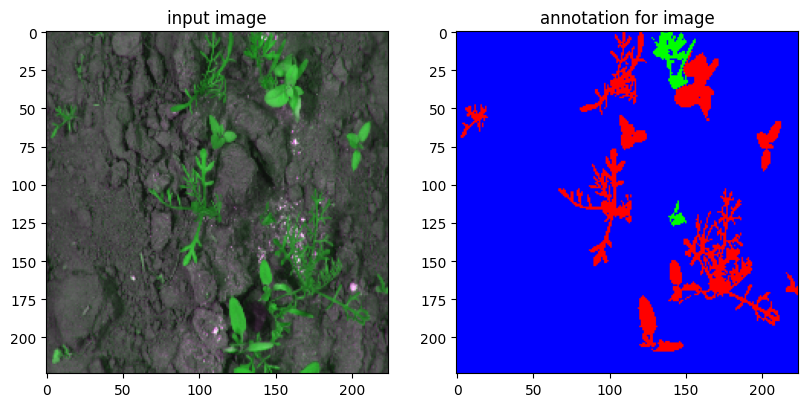

In [21]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.title("input image")
plt.imshow(train_x[0,:,:,:])
plt.subplot(1,3,2)
plt.title("annotation for image")

plt.imshow(train_y[0,:,:,:])
plt.show()

Pretrained unet model

In [23]:
def unet_model_transfer(model):
  inputs = model.input

  x2 = model.get_layer('L2').output
  x5 = model.get_layer('L5').output
  x8 = model.get_layer('L8').output
  x11 = model.get_layer('L11').output
  x = model.get_layer('L14').output


  x15 = layers.Conv2DTranspose(filters=512,kernel_size=(2,2),activation='relu',padding='same',strides=2,name='L15')(x)

  x = layers.Concatenate(name='C1115')([x11,x15])

  x = layers.Conv2D(filters=512,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L16')(x)
  x = layers.Conv2D(filters=512,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L17')(x)
  x18 = layers.Conv2DTranspose(filters=256,kernel_size=(2,2),activation='relu',padding='same',strides=2,name='L18')(x)

  x = layers.Concatenate(name='C818')([x8,x18])

  x = layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L19')(x)
  x = layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L20')(x)
  x21 = layers.Conv2DTranspose(filters=128,kernel_size=(2,2),activation='relu',padding='same',strides=2,name='L21')(x)

  x = layers.Concatenate(name='C521')([x5,x21])

  x = layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L22')(x)
  x = layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L23')(x)
  x24 = layers.Conv2DTranspose(filters=64,kernel_size=(2,2),activation='relu',padding='same',strides=2,name='L24')(x)

  x = layers.Concatenate(name='C224')([x2,x24])

  x = layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L25')(x)
  x = layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',strides=1,name='L26')(x)
  x = layers.Conv2D(filters=3,kernel_size=(1,1),activation='relu',padding='same',strides=1,name='L27')(x)

  x = layers.Activation(activations.softmax,name='A')(x)

  outputs = x

  pretrained_unet = tf.keras.Model(inputs=model.inputs,outputs=outputs, name='pretrained_unet')

  return pretrained_unet

In [36]:
pretrained_unet = unet_model_transfer(model_encoder)
pretrained_unet.summary()

Model: "pretrained_unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 I (InputLayer)              [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 L1 (Conv2D)                 (None, 224, 224, 64)         1792      ['I[0][0]']                   
                                                                                                  
 L2 (Conv2D)                 (None, 224, 224, 64)         36928     ['L1[0][0]']                  
                                                                                                  
 L3 (MaxPooling2D)           (None, 112, 112, 64)         0         ['L2[0][0]']                  
                                                                                    

Training second half of pretrained unet model

In [37]:
# first, only train last layer
for layer in pretrained_unet.layers:
  if "L" in layer.name:
    if int(layer.name.replace("L","")) <= 14:
      print("Setting layer %s to not trainable" % layer.name)
      layer.trainable = False

Setting layer L1 to not trainable
Setting layer L2 to not trainable
Setting layer L3 to not trainable
Setting layer L4 to not trainable
Setting layer L5 to not trainable
Setting layer L6 to not trainable
Setting layer L7 to not trainable
Setting layer L8 to not trainable
Setting layer L9 to not trainable
Setting layer L10 to not trainable
Setting layer L11 to not trainable
Setting layer L12 to not trainable
Setting layer L13 to not trainable
Setting layer L14 to not trainable


In [38]:
BATCH_SIZE = 5
EPOCHS = 50
LEARNING_RATE = 0.001

LOSS = tf.keras.losses.CategoricalCrossentropy()

OPT = optimizer=tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE
)

pretrained_unet.compile(loss=LOSS, optimizer=OPT, metrics=[metrics.CategoricalAccuracy(name='accuracy'),metrics.MeanIoU(num_classes=3,name='IoU')])

In [39]:
%%time
history_2 = pretrained_unet.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/50
8/8 [==============================] - 5s 171ms/step - loss: 0.8557 - accuracy: 0.7046 - IoU: 0.3487
Epoch 2/50
8/8 [==============================] - 1s 167ms/step - loss: 0.4535 - accuracy: 0.9256 - IoU: 0.3333
Epoch 3/50
8/8 [==============================] - 1s 167ms/step - loss: 0.3779 - accuracy: 0.9256 - IoU: 0.3333
Epoch 4/50
8/8 [==============================] - 1s 169ms/step - loss: 0.3190 - accuracy: 0.9256 - IoU: 0.3333
Epoch 5/50
8/8 [==============================] - 1s 169ms/step - loss: 0.3051 - accuracy: 0.9256 - IoU: 0.3333
Epoch 6/50
8/8 [==============================] - 1s 171ms/step - loss: 0.3315 - accuracy: 0.9256 - IoU: 0.3333
Epoch 7/50
8/8 [==============================] - 1s 173ms/step - loss: 0.3169 - accuracy: 0.9256 - IoU: 0.3333
Epoch 8/50
8/8 [==============================] - 1s 170ms/step - loss: 0.3112 - accuracy: 0.9256 - IoU: 0.3333
Epoch 9/50
8/8 [==============================] - 1s 169ms/step - loss: 0.3056 - accuracy: 0.9256 - IoU:

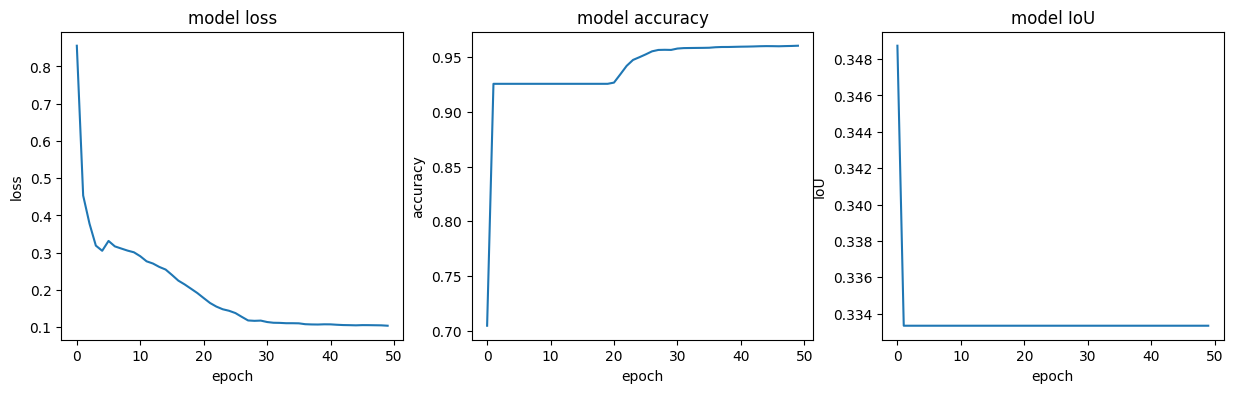

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

axes[0].plot(history_2.history['loss'])
axes[0].set_title('model loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')


axes[1].plot(history_2.history['accuracy'])
axes[1].set_title('model accuracy')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')


axes[2].plot(history_2.history['IoU'])
axes[2].set_title('model IoU')
axes[2].set_xlabel('epoch')
axes[2].set_ylabel('IoU')

plt.show()

Fine-tuning the whole model

In [41]:
# Unlocking al the layers
for layer in pretrained_unet.layers:
  layer.trainable = True

In [42]:
%%time
BATCH_SIZE = 5
EPOCHS = 50
LEARNING_RATE = 0.001

LOSS = tf.keras.losses.CategoricalCrossentropy()

OPT = optimizer=tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE
)

pretrained_unet.compile(loss=LOSS, optimizer=OPT, metrics=[metrics.CategoricalAccuracy(name='accuracy'),metrics.MeanIoU(num_classes=3,name='IoU')])

CPU times: user 15.1 ms, sys: 0 ns, total: 15.1 ms
Wall time: 15.2 ms


In [43]:
history_3 = pretrained_unet.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/50
8/8 [==============================] - 11s 236ms/step - loss: 0.2110 - accuracy: 0.9415 - IoU: 0.3970
Epoch 2/50
8/8 [==============================] - 2s 226ms/step - loss: 0.1299 - accuracy: 0.9584 - IoU: 0.3333
Epoch 3/50
8/8 [==============================] - 2s 225ms/step - loss: 0.1066 - accuracy: 0.9605 - IoU: 0.3333
Epoch 4/50
8/8 [==============================] - 2s 226ms/step - loss: 0.1001 - accuracy: 0.9627 - IoU: 0.3333
Epoch 5/50
8/8 [==============================] - 2s 227ms/step - loss: 0.0939 - accuracy: 0.9641 - IoU: 0.3333
Epoch 6/50
8/8 [==============================] - 2s 229ms/step - loss: 0.0909 - accuracy: 0.9651 - IoU: 0.3333
Epoch 7/50
8/8 [==============================] - 2s 232ms/step - loss: 0.0886 - accuracy: 0.9659 - IoU: 0.3333
Epoch 8/50
8/8 [==============================] - 2s 233ms/step - loss: 0.0869 - accuracy: 0.9667 - IoU: 0.3333
Epoch 9/50
8/8 [==============================] - 2s 230ms/step - loss: 0.0859 - accuracy: 0.9673 - IoU

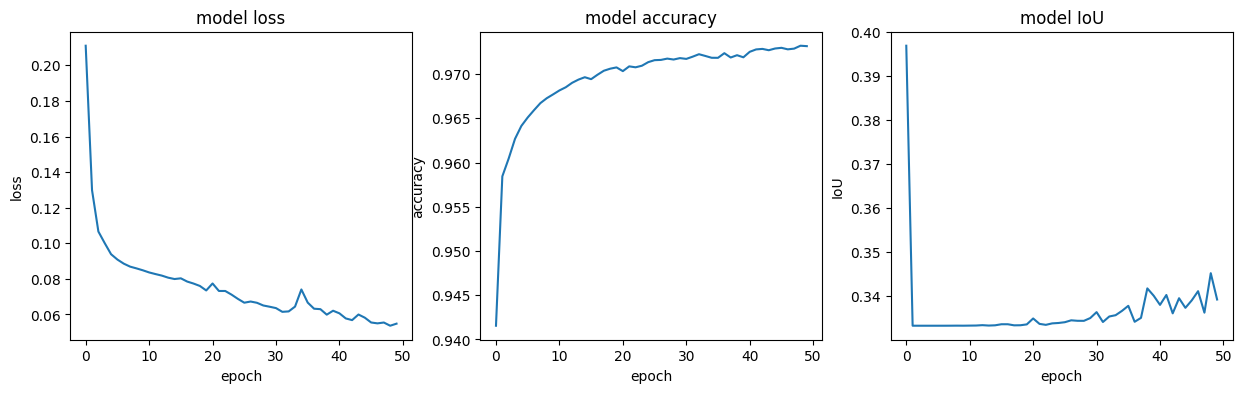

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

axes[0].plot(history_3.history['loss'])
axes[0].set_title('model loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')

axes[1].plot(history_3.history['accuracy'])
axes[1].set_title('model accuracy')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')

axes[2].plot(history_3.history['IoU'])
axes[2].set_title('model IoU')
axes[2].set_xlabel('epoch')
axes[2].set_ylabel('IoU')

plt.show()

Accuracy on test data

In [45]:
%%time
test_scores = pretrained_unet.evaluate(test_x, test_y, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

1/1 - 12s - loss: 0.0592 - accuracy: 0.9743 - IoU: 0.3371 - 12s/epoch - 12s/step
Test loss: 0.05917216092348099
Test accuracy: 0.9743417501449585
CPU times: user 11.8 s, sys: 45.3 ms, total: 11.9 s
Wall time: 21.6 s


Visualization

In [47]:
y_pred = pretrained_unet(train_x)
y_pred_lb = tf.math.argmax(y_pred, axis=-1)
print(y_pred_lb.shape)
y_hat = tf.one_hot(y_pred_lb, 3)
print(y_hat.shape)

(40, 224, 224)
(40, 224, 224, 3)


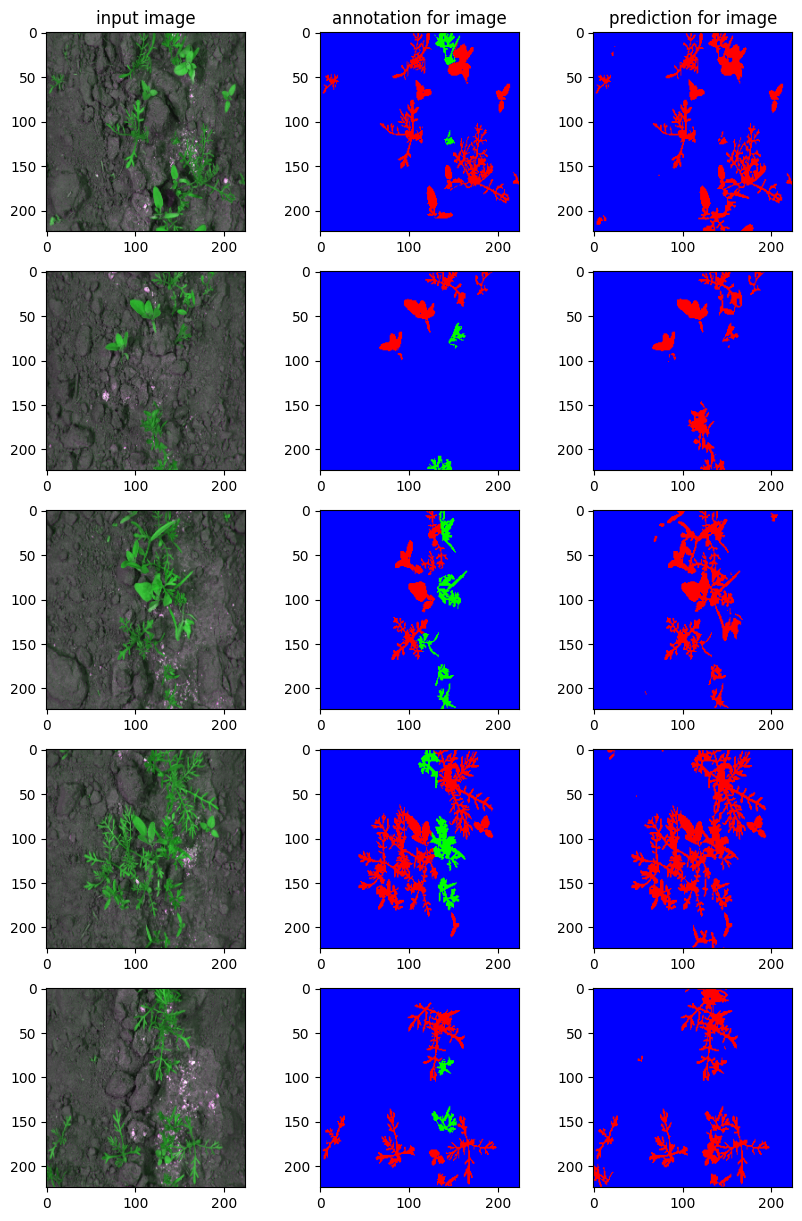

In [48]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,15))

for _ in range(5):
  x_n = train_x[_]
  y_true_n = train_y[_]
  y_hat_n = y_hat[_]

  axes[_, 0].imshow(x_n)
  axes[_, 1].imshow(y_true_n)
  axes[_, 2].imshow(y_hat_n)

axes[0, 0].set_title(f"input image")
axes[0, 1].set_title("annotation for image")
axes[0, 2].set_title("prediction for image")

plt.show()

Conclusion

This notebook correctly implement transfer learning between two different tasks:

* Pre-training with classification on deep weed dataset
* Fine-tuning with segmentation on CWFID dataset

However, the results show even though the model is able to learn to recognize the presence of vegetation more quickly, it is incapable of learning to differentiate between crops and weeds as quickly.
